# Imports

In [20]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
from tqdm.contrib.concurrent import thread_map
from typing import Optional, Tuple, Union, Sequence, Dict, Callable, Any
import matplotlib.pyplot as plt
from tqdm import tqdm
from anonymeter.evaluators import SinglingOutEvaluator
from tqdm.notebook import tqdm, trange

# User Settings

In [21]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    sampling_size: int = None # None if no sampling

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

In [22]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [23]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

In [24]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

## Sampling

In [25]:
if cfg.sampling_size is not None: # stratify bzw. weights führt zu Fehler: ausschließlich True
    df_train = df_train.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_synth = df_synth.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_holdout = df_holdout.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)

# Pilot-Studie
**Ziel:**
- Prüfen, ob Angriffe erfolgreich sind.
- Erste grobe Schätzung des Singling-Out-Risikos.

**Vorgehen:**
1. Parameter:
   - n_attacks = 500
   - max_attempts = 50 000
   - n_cols = 3
2. SinglingOutEvaluation durchführen (parallelisiert).
3. Ergebnis:
   1. Ich erhielt zunächst unter max_attemps = n_attacks * 10 viele Warnungen, dass die n_attacks nicht erreicht wurden Die Singling-Out-Erfolgsrate war ca. 4 +/- 2%. Der Anteil genutzter max_attemps war praktisch 100%
   2. Nach zunächst Singulärer Testung mit n_attacks 50 und max_attemps 50_000 gab es keine Warnungen mehr.
   3. In Parallelislierung mit n_attacks = 500 und max_attemps = None war (logischerweise) der Anteil genutzter max_attemps = 0%, die Singling-Out-Rate 0.1471, die Laufzeit ca. 5 Min.
   4. Nunmehr max_attemps = n_attacks*1000 bei n_attacks=500 in Parallel: Lief ebenfalls durch. Anteil genutzter max_attemps = 0%, Singling-Out Erfolgsrate: 0.1397. Laufzeit ca. 6 Min. (warum auch immer)

Nebenbefund: "UserWarning: Attack is as good or worse as baseline model." bedeutet, dass die n_attacks zu klein ist (Erfolgsrate entspricht dem Zufallsmodell)

## Ohne Parallelisierung

In [ ]:
def run_singling_out(ori, syn, n_attacks, n_cols, max_attempts):
    evaluator = SinglingOutEvaluator(
        ori=ori,
        syn=syn,
        n_attacks=n_attacks,
        n_cols=n_cols,
        max_attempts=max_attempts
    )
    result = evaluator.evaluate()
    # return result['success_rate']
    return result

In [ ]:
pilot_success = run_singling_out(df_train, df_synth, n_attacks=50, n_cols=3, max_attempts=50000)



In [ ]:
pilot_success.risk().value
pilot_success.risk().ci[1]

## Mit Parallelisierung

In [ ]:
total_n_attacks = 50  # Gesamtziel Pilot-Studie
n_jobs = 11             # Anzahl paralleler Kerne
attacks_per_job = total_n_attacks // n_jobs
n_cols = 3
# Safety für max_attempts pro Job (z.B. 10x Angriffe pro Job)
max_attempts_per_job = attacks_per_job * 1000

In [ ]:
def partial_singling_out(random_seed):
    # Explizites Setzen des Random Seeds, hoffentlich durch Anonymeter intern angewandt.
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    evaluator = SinglingOutEvaluator(
        ori=df_train,
        syn=df_synth,
        n_attacks=attacks_per_job,
        n_cols=n_cols,
        max_attempts=max_attempts_per_job
        # max_attempts=None
    )
    
    pr = evaluator.evaluate().risk()
    return {"value": pr.value, "ci_lower": pr.ci[0], "ci_upper": pr.ci[1]}



In [ ]:
# 5 Min auf None
seeds = list(range(n_jobs))
risk = thread_map(partial_singling_out, seeds, max_workers=n_jobs)

In [ ]:
risk = pd.DataFrame(risk, columns=['value', 'ci_lower', 'ci_upper'])
print(risk['value'].mean(), risk['ci_lower'].mean(), risk['ci_upper'].mean())

# overall_success_rate = np.mean(risk, axis=0)[0]
# print(f"Pilot-Studie (parallelisiert) Singling-Out Erfolgsrate: {overall_success_rate:.4f}")

# Konvergenz-Check
**Ziel:**
- Sicherstellen, dass mehr Angriffe zu keiner starken Änderung der Risikoschätzung führen.

**Vorgehen:**
1. Gleiche Analyse mit steigendem n_attacks aus:
   - z.B. 500 → 1 000 → 2 500 → 5 000.
   - Der ermittelte max_attempts Faktor (1000x) wird beibehalten (n_attacks = 5 000 → max_attemps = 5_000_000).
2. Beobachte:
   - Wie stark verändert sich die Singling-Out-Erfolgsrate?
   - Ist der Unterschied zwischen 2 500 und 5 000 Angriffen < 1 % → Konvergenz erreicht.
   - Wird max_attempts ausgeschöpft?
   - Falls ja: Erhöhung nötig.

## Ohne Parallelisierung

In [ ]:
# n_attacks_list = [500, 1000, 2500, 5000]
# convergence_results = []

# for n_attacks in n_attacks_list:
#     success_rate = run_singling_out(original_data, synthetic_data, n_attacks=n_attacks, n_cols=3, max_attempts=n_attacks*10)
#     convergence_results.append(success_rate)
#     print(f"n_attacks={n_attacks}: Erfolgsrate = {success_rate:.4f}")

# # Plot Konvergenz-Check
# plt.figure()
# plt.plot(n_attacks_list, convergence_results, marker='o')
# plt.xlabel('n_attacks')
# plt.ylabel('Singling-Out Erfolgsrate')
# plt.title('Konvergenz-Check')
# plt.grid(True)
# plt.show()

## Mit Parallelisierung

In [26]:
n_jobs = 12             # Anzahl paralleler Kerne
n_cols = 3

In [ ]:
# n_attacks_list = [500, 1000, 2500, 5000]
# n_attacks_list = [12, 30, 50, 100]
n_attacks_list = [12, 30, 50, 100, 200, 500, 1000, 1500, 2000, 2500]
convergence_results_parallel = {}

for n_attacks in n_attacks_list:
    print(f"n_attacks={n_attacks} ------------------------------------")
    # Aufteilung der Angriffe pro Job
    attacks_per_job = n_attacks // n_jobs
    max_attempts_per_job = attacks_per_job * 1000

    # Partial-Funktion für diesen n_attacks-Wert
    def partial_convergence(random_seed):

        random.seed(random_seed)
        np.random.seed(random_seed)

        evaluator = SinglingOutEvaluator(
            ori=df_train,
            syn=df_synth,
            n_attacks=attacks_per_job,
            n_cols=n_cols,
            max_attempts=max_attempts_per_job
        )
        pr = evaluator.evaluate().risk()
        return {"value": pr.value, "ci_lower": pr.ci[0], "ci_upper": pr.ci[1]}

    # Paralleler Aufruf mit Fortschrittsbalken
    seeds = list(range(n_jobs))
    results = thread_map(partial_convergence, seeds, max_workers=n_jobs)
    convergence_results_parallel[n_attacks] = results

In [ ]:
rows = []
for n_attacks, runs in convergence_results_parallel.items():
    values    = [r["value"]    for r in runs]
    ci_lowers = [r["ci_lower"] for r in runs]
    ci_uppers = [r["ci_upper"] for r in runs]
    rows.append({
        "n_attacks":    n_attacks,
        "mean_value":   np.mean(values),
        "mean_ci_low":  np.mean(ci_lowers),
        "mean_ci_high": np.mean(ci_uppers),
    })

df_convergence = pd.DataFrame(rows).sort_values("n_attacks")
print(df_convergence)
if cfg.save_data:
    df_convergence.to_csv(cfg.results_dir / f"Singling-Out_convergence_ncols-{n_cols}_{current_timestamp}.csv", index=False, header=True, decimal=",", sep=";", encoding="utf-8")

In [27]:
df_convergence = pd.read_csv(cfg.results_dir / f"Singling-Out_convergence_ncols-3_20250515_002024.csv", sep=";", decimal=",")

Abbildung gespeichert unter: figures\Singling-Out_convergence_ncols-3_20250601_124329.tiff


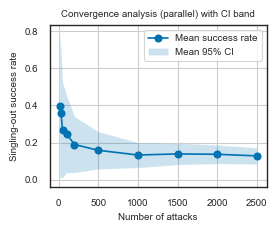

In [28]:
plt.figure(figsize=(2.8, 2.1))
plt.plot(
    df_convergence["n_attacks"],
    df_convergence["mean_value"],
    marker="o",
    label="Mean success rate"
)
plt.fill_between(
    df_convergence["n_attacks"],
    df_convergence["mean_ci_low"],
    df_convergence["mean_ci_high"],
    alpha=0.2,
    label="Mean 95% CI"
)
plt.xlabel("Number of attacks")
plt.ylabel("Singling-out success rate")
plt.title("Convergence analysis (parallel) with CI band")
plt.grid(True)
plt.legend()
if cfg.save_data:
    fname = f'Singling-Out_convergence_ncols-{n_cols}_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()


# Sensitivitätsanalyse
**Ziel:**
- Prüfen, wie das Risiko auf andere Angreiferfähigkeiten reagiert.

Vorgehen:
1. Variiere n_cols:
   - z.B. Werte wie 2, 3, 4, 5 testen.
   - Halte n_attacks fix bei z.B. 2 500.
   - Setze max_attempts großzügig (z.B. 100 000), da hohe n_cols schwieriger sind.
2. Dokumentiere:
   - Wie steigt/sinkt das Singling-Out-Risiko mit mehr bekannten Attributen?
   - Wie stark sinkt die Angriffserfolgsrate bei höherem n_cols?
3. Ergebnisse:
   - Plot: Singling-Out-Risiko vs. n_attacks (für Konvergenzcheck).
   - Plot: Singling-Out-Risiko vs. n_cols (für Sensitivitätsanalyse).
   - Angabe der jeweils verwendeten Parameter (n_attacks, max_attempts, n_cols)
   - Hinweis auf Limitierungen (falls z.B. bei hohen n_cols kaum noch Angriffe erfolgreich).

In [29]:
n_cols_list = [2, 3, 4, 5]
n_attacks = 2500
n_jobs = 12

In [ ]:
sensitivity_results_parallel = {}

for n_cols in n_cols_list:
    attacks_per_job = n_attacks // n_jobs
    max_attempts_per_job = attacks_per_job * 1000
    print(f"n_cols={n_cols} ------------------------------------")
    
    def partial_sensitivity(random_seed):
        random.seed(random_seed)
        np.random.seed(random_seed)

        evaluator = SinglingOutEvaluator(
            ori=df_train,
            syn=df_synth,
            n_attacks=attacks_per_job,
            n_cols=n_cols,
            max_attempts=max_attempts_per_job
        )
        pr = evaluator.evaluate().risk()
        return {"value": pr.value, "ci_lower": pr.ci[0], "ci_upper": pr.ci[1]}

    seeds = list(range(n_jobs))
    results = thread_map(partial_sensitivity, seeds, max_workers=n_jobs)

    sensitivity_results_parallel[n_cols] = results

In [ ]:
rows = []
for n_cols, runs in sensitivity_results_parallel.items():
    values    = [r["value"]    for r in runs]
    ci_lowers = [r["ci_lower"] for r in runs]
    ci_uppers = [r["ci_upper"] for r in runs]
    rows.append({
        "n_cols": n_cols,
        "mean_value": np.mean(values),
        "mean_ci_low": np.mean(ci_lowers),
        "mean_ci_high": np.mean(ci_uppers),
    })

df_sensitivity = pd.DataFrame(rows).sort_values("n_cols")
display(df_sensitivity)
if cfg.save_data:
    df_sensitivity.to_csv(cfg.results_dir / f"Singling-Out_sensitivity_attacks-{n_attacks}_{current_timestamp}.csv", index=False, header=True, decimal=",", sep=";", encoding="utf-8")

In [14]:
df_sensitivity = pd.read_csv(cfg.results_dir / f"Singling-Out_sensitivity_attacks-2500_20250515_042224.csv", sep=";", decimal=",")

Abbildung gespeichert unter: figures\Singling-Out_sensitivity_attacks-2500_20250601_124329.tiff


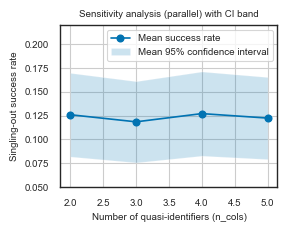

In [30]:
plt.figure(figsize=(2.8, 2.1))
plt.plot(
    df_sensitivity["n_cols"],
    df_sensitivity["mean_value"],
    marker="o",
    label="Mean success rate"
)
plt.fill_between(
    df_sensitivity["n_cols"],
    df_sensitivity["mean_ci_low"],
    df_sensitivity["mean_ci_high"],
    alpha=0.2,
    label="Mean 95% confidence interval"
)
plt.xlabel("Number of quasi-identifiers (n_cols)")
plt.ylabel("Singling-out success rate")
plt.ylim(0.05, 0.22)
plt.title("Sensitivity analysis (parallel) with CI band")
plt.grid(True)
plt.legend(loc='upper right')
if cfg.save_data:
    fname = f'Singling-Out_sensitivity_attacks-{n_attacks}_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()